In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import pickle
from collections import namedtuple
from itertools import product
from copy import copy
from os.path import join

import numpy as np
import pandas as pd
import seaborn as sns
from aeff_calculations import calc_aeff_factor
from fluxes import (
    astro_flux,
    atmo_background,
    cut_off,
    power_law,
)
import mephisto
from matplotlib.colors import LogNorm
from scipy.optimize import fmin_l_bfgs_b
from scipy.stats import chi2, norm
from settings import *
from tools import array_source_interp, poisson_llh
from tqdm import tqdm


# Settings

In [3]:
# energy resolution files
e_res_files = {
    "baseline": join(LOCALPATH, "energy_smearing_MH_up.pckl"),
    "reproduction": join(LOCALPATH, "artificial_smoothed_energy_smearing_MH_up.pckl"),
    "1:1": join(LOCALPATH, "idealized_artificial_energy_smearing_MH_up.pckl"),
    "improved-20": join(LOCALPATH, "improved_0.2_artificial_energy_smearing_MH_up.pckl"),
    "improved-50": join(LOCALPATH, "improved_0.5_artificial_energy_smearing_MH_up.pckl"),
}

# plot settings for different configurations
det_plotting = {
    "IceCube": {
        "color": "k",
        "ls": "-",
        "label": "IceCube",
        "plainlabel": "IceCube",
        "marker": "d",
    },
    "P-ONE": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC + P-ONE",
        "plainlabel": "P-ONE",
        "marker": "v",
    },
    "Plenum-1": {
        "color": "#339999",
        "ls": "-",
        "label": r"IC + PLE$\nu$M-1",
        "plainlabel": r"PLE$\nu$M-1",
        "marker": "s",
    },
    "Plenum-2": {
        "color": "#a50000",
        "ls": "-.",
        "label": r"IC + PLE$\nu$M-2",
        "plainlabel": r"PLE$\nu$M-2",
        "marker": "o",
    },
}


# Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [4]:
with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)

# Background

In [5]:
with open(join(LOCALPATH, "atmospheric_background_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)

# Energy resolution function

Plotting code can be found in `energy_resolution.ipynb`

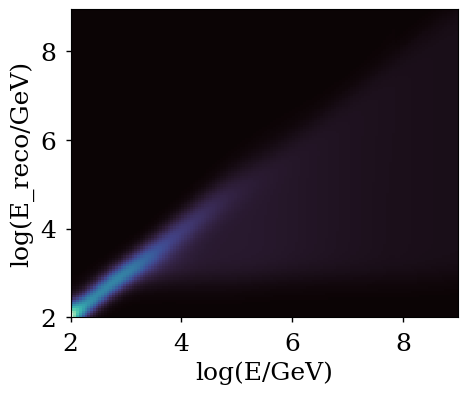

In [6]:
# baseline resolution
with open(e_res_files["baseline"], "rb") as f:
    baseline_eres = pickle.load(f)
baseline_eres.normalize(axis=1) # normalize per logE_true

# resolution improved by 50%
with open(e_res_files["improved-50"], "rb") as f:
    improved_eres = pickle.load(f)
improved_eres.normalize(axis=1) # normalize per logE_true

improved_eres.plot()

# PSF-Energy grid from the smearing matrix

In [7]:
# angular resolution
with open(join(LOCALPATH, "Psi2_res_mephistograms.pckl"), "rb") as f:
    all_psi = pickle.load(f)
e_psi2_grid = all_psi["dec-0.0"]
e_psi2_grid.normalize()

# uniform, normalized background grid
bckg_psi2_grid = mephisto.like(e_psi2_grid, fill_value=1)
bckg_psi2_grid.normalize()

# Flux definition

In [8]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
PLcut_flux = namedtuple("PLcut_flux", "norm gamma e_cut E0 shape")
LogP_flux = namedtuple("LogP_flux", "norm alpha beta E0 shape")

flux_collection = {
    "powerlaw": PL_flux,
    "powerlaw with cutoff": PLcut_flux,
    "log-parabola": LogP_flux,
}

## NGC1068 and TXS0506 source parameters

In [9]:
# 10yr PS PAPER PARAMETERS of NGC 1068
GAMMA_NGC = 3.2
PHI_NGC = 5E-14 # @ 1 TeV / GeV cm² s
E0_NGC = 1E3

# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt(join(BASEPATH, "local/ngc_paper_68_contour.txt"))
phi_c_68 /= 1E11

# TXS parameters
with open(join(BASEPATH, "local/txs_contour.pkl"), "rb") as f:
    txs_contour = pickle.load(f)

GAMMA_TXS = 2.
PHI_TXS = 2.7E-20
E0_TXS = txs_contour["E0"] 

ngc_flux = PL_flux(PHI_NGC, GAMMA_NGC, E0_NGC, "powerlaw")
txs_flux = PL_flux(PHI_TXS, GAMMA_TXS, E0_TXS, "powerlaw")


In [10]:
# generic source config without dec coordinate
src_config = dict(
    sindec_mids=sindec_mids,
    livetime=LIVETIME,
    ewidth=ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = delta_psi_max
bg_config["grid_2d"] = bckg_psi2_grid

# ... with ngc declination
ngc_src_config = copy(src_config)
ngc_src_config["dec"] = ngc1068.dec.rad
ngc_bg_config = copy(bg_config)
ngc_bg_config["dec"] = ngc1068.dec.rad

# ... with txs declination
txs_src_config = copy(src_config)
txs_src_config["dec"] = txs0506.dec.rad
txs_bg_config = copy(bg_config)
txs_bg_config["dec"] = txs0506.dec.rad


## Check event numbers

In [11]:
ident = "IceCube"
# check that the bins match
assert (aeff_2d[ident].bins[1] == ngc_src_config["grid_2d"].bins[1]).all()
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

k_s = astro_flux(
    aeff_factor_signal,
    emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print("ngc 1068:", np.sum(k_s))  # ~85


## check event numbers
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **txs_src_config)
k_s = astro_flux(
    aeff_factor_signal,
    emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=txs_flux,
)
print("txs 0506+056:", np.sum(k_s))  # ~5

ngc 1068: 85.16201580234387
txs 0506+056: 4.933533815353144


# Set up LLH function

In [12]:
def ps_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0,
    phi_0,
    shape,
    energy_resolution,
    verbose=False,
):
    """fit parameters in x:
    x[0]: background normalization scaling
    x[1]: signal normalization scaling
    x[2:]: other signal parameters
        see 'astro_flux' for further shapes and parameters

    mu_b_base: background baseline
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_0: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    shape: flux shape
    """
    mu_b = mu_b_base * x[0]
    mu_s = astro_flux(
        mu_s_base,
        emids,
        energy_resolution,
        x[1],
        flux_collection[shape](
            phi_0, *x[2:], e_0, shape
        ),  # here we generate a flux tuple with the current parameters
    )
    if verbose:
        print(x[0], x[1], *x[2:])
        print(flux_collection[shape](phi_0, *x[2:], e_0, shape))
        print(np.sum(mu_b), np.sum(mu_s))
    mu_i = mu_s + mu_b

    return poisson_llh(mu_i, k_i)


# Nominal PS fit

In [13]:
ident = "IceCube"

aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
if "Plenum" in ident or "P-ONE" in ident:
    aeff_factor_bckg += calc_aeff_factor(aeff_2d["IceCube"], **ngc_bg_config)
    aeff_factor_signal += calc_aeff_factor(aeff_2d["IceCube"], **ngc_src_config)
# asimov data
k_b = atmo_background(
    aeff_factor=aeff_factor_bckg,
    bckg_vals=array_source_interp(ngc_src_config["dec"], bckg_histo, sindec_mids, axis=1),
    energy_resolution=baseline_eres,
)
# power law
k_s = astro_flux(
    aeff_factor=aeff_factor_signal,
    emids=emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,  # powerlaw
)
k_i = k_s + k_b

print("Asimov data sum:")
print("Background:", np.sum(k_b))
print("Signal:", np.sum(k_s))


dct = dict(
    shape="powerlaw",
    mu_b_base=k_b,
    mu_s_base=aeff_factor_signal,
    k_i=k_i,
    e_0=ngc_flux.E0,
    phi_0=ngc_flux.norm,
    energy_resolution=baseline_eres,
)

# fix signal normalization to 0
local_llh = lambda x: ps_llh_2d_composite((x[0], 0, 3), **dct)
global_llh = lambda x: ps_llh_2d_composite(x, **dct)

out_bckg = fmin_l_bfgs_b(
    local_llh,
    x0=(1,),
    approx_grad=True,
)
print("Atmo-only normalization:", out_bckg[0])

# this fit is not really needed, but good for crosschecking the code
out_comp = fmin_l_bfgs_b(
    global_llh,
    x0=(1, 1, ngc_flux.gamma),
    approx_grad=True,
)
print("Signal fit parameters:", out_comp[0])
print("TS check:", global_llh((1, 1, ngc_flux.gamma)), "(fit: ", out_comp[1], ")")
print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
significance = norm.isf(pval)
print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
print()

Asimov data sum:
Background: 1171.0718512641517
Signal: 85.16201580234387
Atmo-only normalization: [1.07271634]
Signal fit parameters: [1.  1.  3.2]
TS check: -350386.06679417443 (fit:  -350386.06679417443 )
-2 Delta LLH: 20.42662353097694
P-VALUE: 3.667879490160778e-05 SIGNIFICANCE: 3.965124691206231



# Scan energy threshold
## Standard PS and energy spectrum

 cut on E_reco


In [14]:
## NGC 1068 and TXS 0506+056
# analysis region in distance to source
verbose = False
results = []
idents = ["IceCube", "Plenum-1", "Plenum-2"]
sources = ["ngc", "txs"]
enums = len(logE_reco_mids[logE_reco_mids<=5]) + 1

for i, ident, source in product(range(enums), idents, sources):
    if source == "ngc":
        src_coords = ngc1068
        src_flux = ngc_flux
    elif source == "txs":
        src_coords = txs0506
        src_flux = txs_flux

    # energy smearing
    energy_resolution_thresh = mephisto.Mephistogram(
        baseline_eres[:, i:],
        bins=(baseline_eres.bins[0], baseline_eres.bins[1][i:]),
        axis_names=baseline_eres.axis_names,
    )

    ## number of events
    aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
    aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
    if "Plenum" in ident or "P-ONE" in ident:
        aeff_factor_bckg += calc_aeff_factor(aeff_2d["IceCube"], **ngc_bg_config)
        aeff_factor_signal += calc_aeff_factor(aeff_2d["IceCube"], **ngc_src_config)
    # asimov data
    k_b = atmo_background(
        aeff_factor=aeff_factor_bckg,
        bckg_vals=array_source_interp(ngc_src_config["dec"], bckg_histo, sindec_mids, axis=1),
        energy_resolution=energy_resolution_thresh,
    )
    # power law
    k_s = astro_flux(
        aeff_factor=aeff_factor_signal,
        emids=emids,
        energy_resolution=energy_resolution_thresh,
        phi_scaling=1,
        flux_shape=src_flux,  # powerlaw
    )
    k_i = k_s + k_b

    dct = dict(
        shape="powerlaw",
        mu_b_base=k_b,
        mu_s_base=aeff_factor_signal,
        k_i=k_i,
        e_0=src_flux.E0,
        phi_0=src_flux.norm,
        energy_resolution=energy_resolution_thresh,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_2d_composite((x[0], 0, 3), **dct)
    global_llh = lambda x: ps_llh_2d_composite(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )

    # this fit is not really needed, but good for crosschecking the code
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, src_flux.gamma),
        approx_grad=True,
    )
    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = norm.isf(pval)
    for out in [out_bckg, out_comp]:
        if out[2]["warnflag"] == 2:
            print("WARNING, bg failed")
            print(out)

    results.append(
        {
            r"$\log_{10}(E_{\rm thresh} / {\rm GeV})$": logE_reco_mids[i],
            "ident": ident,
            "Detector": det_plotting[ident]["plainlabel"],
            "Source": source,
            "PL index": fr"$\gamma$ = {src_flux.gamma}",
            "p-value": pval,
            "Significance": significance,
            "n_s": np.sum(k_s),
            "n_b": np.sum(k_b),
        }
    )

    if verbose:
        print("Asimov data sum:")
        print("Background:", np.sum(k_b))
        print("Signal:", np.sum(k_s))
        print("Signal fit parameters:", out_comp[0])
        print(
            "TS check:", global_llh((1, 1, src_flux.gamma)), "(fit: ", out_comp[1], ")"
        )
        print("-2 Delta LLH:", out_bckg[1] - out_comp[1])
        print("Atmo-only normalization:", out_bckg[0])
        print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
        break

results = pd.DataFrame(results)
results.to_pickle(join(LOCALPATH, "ps_performance_e-thresh.pickle"))

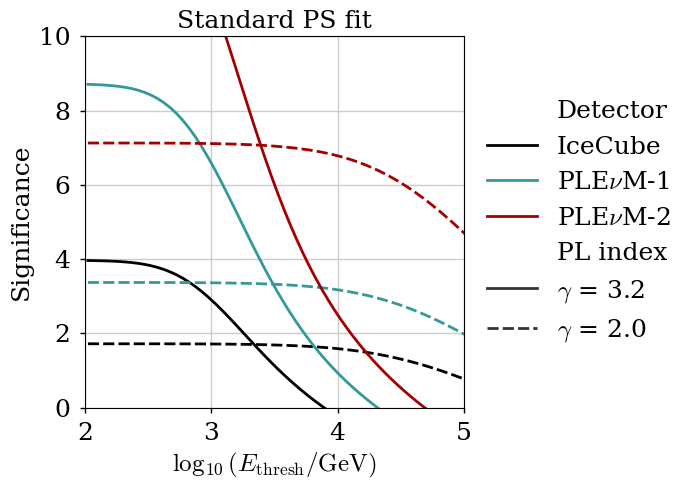

In [15]:
results = pd.read_pickle(join(LOCALPATH, "ps_performance_e-thresh.pickle"))
f, ax = plt.subplots(figsize=(7, 5))
ax = sns.lineplot(
    data=results,
    x=r"$\log_{10}(E_{\rm thresh} / {\rm GeV})$",
    y="Significance",
    hue="Detector",
    style="PL index",
    palette=[det_plotting[ident]["color"] for ident in idents],
)
ax.set_ylim(0, 10)
ax.set_xlim(2, 5)
ax.set_title("Standard PS fit")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False)
f.tight_layout()
f.savefig("../../plots/ngc_paper/energy_threshold_significance_scan.pdf")


## NGC spectral shape + energy threshold

In [16]:
# cutoff parameters
# see energy_spectrum_wiggle.ipynb for 'optimization'
# of these parameters
ident = "IceCube"
Gamma_cut = 2.0
logE_cut = 3.5 # log10 (Ecut / GeV)

tmp_flux = PLcut_flux(
    PHI_NGC, Gamma_cut, logE_cut, E0_NGC, "powerlaw with cutoff"
)

## check event numbers
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
astro_ev_sum_pl = np.sum(
    astro_flux(
        aeff_factor_signal,
        emids,
        baseline_eres,
        1,
        ngc_flux,
    )
)

# cutoff
astro_ev_sum_cut = np.sum(
    astro_flux(
        aeff_factor_signal,
        emids,
        baseline_eres,
        1,
        tmp_flux,
    )
)
flux_scaling_cut = astro_ev_sum_pl / astro_ev_sum_cut
print("flux_scaling_cut", flux_scaling_cut) 
print("flux normalization before", PHI_NGC, "after", PHI_NGC * flux_scaling_cut)

# define the correctly normalized PL+cut flux for NGC 1068
ngc_cut_flux = PLcut_flux(
    PHI_NGC * flux_scaling_cut, Gamma_cut, logE_cut, E0_NGC, "powerlaw with cutoff"
)


flux_scaling_cut 1.4280687990906449
flux normalization before 5e-14 after 7.140343995453224e-14


In [17]:
## NGC 1068 and TXS 0506+056
# analysis region in distance to source
verbose = False
results = []
idents = ["IceCube", "Plenum-1", "Plenum-2"]
source = "ngc"
enums = len(logE_reco_mids[logE_reco_mids <= 5]) + 1

### using improved energy resolution ###

for i, ident in product(range(enums), idents):

    # energy smearing
    ### using improved energy resolution ###
    energy_resolution_thresh = mephisto.Mephistogram(
        improved_eres[:, i:],
        bins=(improved_eres.bins[0], improved_eres.bins[1][i:]),
        axis_names=improved_eres.axis_names,
    )

    ## number of events
    aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
    aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
    if "Plenum" in ident or "P-ONE" in ident:
        aeff_factor_bckg += calc_aeff_factor(aeff_2d["IceCube"], **ngc_bg_config)
        aeff_factor_signal += calc_aeff_factor(aeff_2d["IceCube"], **ngc_src_config)
    # asimov data
    k_b = atmo_background(
        aeff_factor=aeff_factor_bckg,
        bckg_vals=array_source_interp(ngc_src_config["dec"], bckg_histo, sindec_mids, axis=1),
        energy_resolution=energy_resolution_thresh,
    )
    # power law
    k_s = astro_flux(
        aeff_factor=aeff_factor_signal,
        emids=emids,
        energy_resolution=energy_resolution_thresh,
        phi_scaling=1,
        flux_shape=ngc_cut_flux,  # powerlaw with cutoff
    )
    k_i = k_s + k_b

    dct = dict(
        mu_b_base=k_b,
        mu_s_base=aeff_factor_signal,
        k_i=k_i,
        e_0=ngc_flux.E0,
        phi_0=ngc_flux.norm,
        energy_resolution=energy_resolution_thresh,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_2d_composite(x, shape="powerlaw", **dct)
    global_llh = lambda x: ps_llh_2d_composite(x, shape="powerlaw with cutoff", **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1.2, 1.2, 3.0),
        approx_grad=True,
    )

    # this fit is not really needed, but good for crosschecking the code
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1.2, 1.1, 1.9, 3.4),
        approx_grad=True,
    )
    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = norm.isf(pval)
    for out in [out_bckg, out_comp]:
        if out[2]["warnflag"] == 2:
            print("WARNING, bg failed")
            print(out)

    results.append(
        {
            r"$\log_{10}(E_{\rm thresh} / {\rm GeV})$": logE_reco_mids[i],
            "ident": ident,
            "Detector": det_plotting[ident]["plainlabel"],
            "Source": source,
            "p-value": pval,
            "Significance": significance,
            "n_s": np.sum(k_s),
            "n_b": np.sum(k_b),
            "Energy Reco": "50% improved",
        }
    )

    if verbose:
        print("Asimov data sum:")
        print("Background:", np.sum(k_b))
        print("Signal:", np.sum(k_s))
        print("Signal fit parameters:", out_comp[0])
        print(
            "TS check:", global_llh((1, 1, src_flux.gamma)), "(fit: ", out_comp[1], ")"
        )
        print("-2 Delta LLH:", out_bckg[1] - out_comp[1])
        print("Atmo-only normalization:", out_bckg[0])
        print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
        break

results = pd.DataFrame(results)
results.to_pickle(join(LOCALPATH, "ngc_performance_e-thresh.pickle"))

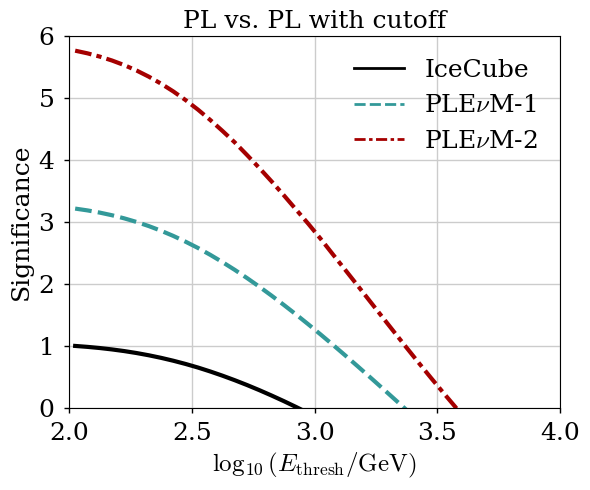

In [18]:
results = pd.read_pickle(join(LOCALPATH, "ngc_performance_e-thresh.pickle"))
f, ax = plt.subplots(figsize=(6, 5))
ax = sns.lineplot(
    data=results,
    x=r"$\log_{10}(E_{\rm thresh} / {\rm GeV})$",
    y="Significance",
    hue="Detector",
    style="Detector",
    palette=[det_plotting[ident]["color"] for ident in idents],
    lw=3,
    dashes=[
        "",
        (4, 1.5),
        (4, 1.25, 1.25, 1.25),
    ],
)
ax.set_ylim(0, 6)
ax.set_xlim(2, 4)
ax.set_title("PL vs. PL with cutoff")
ax.legend(loc=1, frameon=False)  # , bbox_to_anchor=(1, 0.5), frameon=False)
f.tight_layout()
f.savefig("../../plots/ngc_paper/energy_threshold_significance_spectral_scan.pdf")


### combined plot

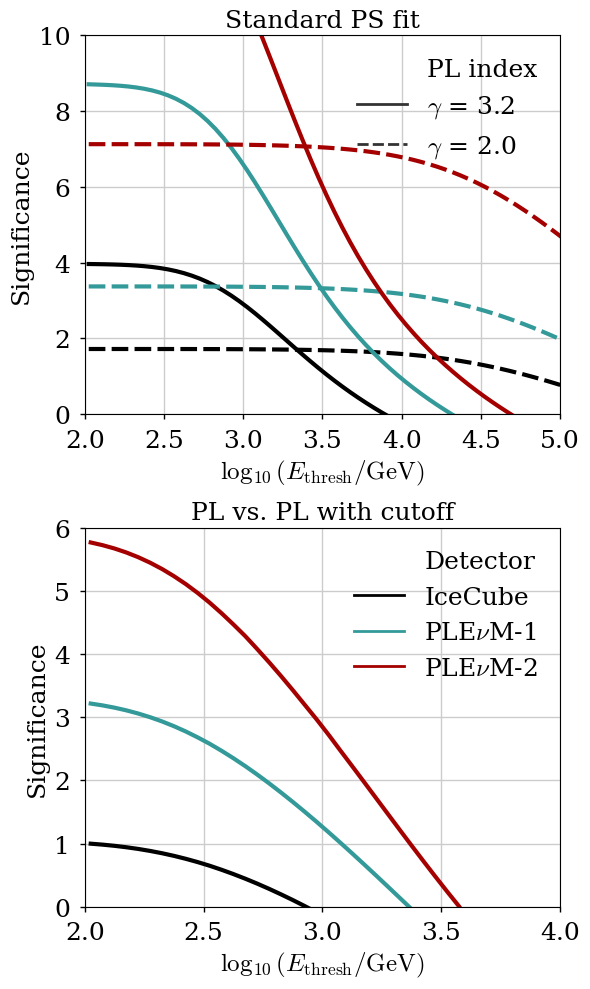

In [19]:
results = pd.read_pickle(join(LOCALPATH, "ps_performance_e-thresh.pickle"))
f, axes = plt.subplots(nrows=2, figsize=(6, 10))
ax = sns.lineplot(
    data=results,
    x=r"$\log_{10}(E_{\rm thresh} / {\rm GeV})$",
    y="Significance",
    hue="Detector",
    style="PL index",
    palette=[det_plotting[ident]["color"] for ident in idents],
    ax=axes[0],
    lw=3,
)
ax.set_ylim(0, 10)
ax.set_xlim(2, 5)
ax.set_title("Standard PS fit")
h, l = ax.axes.get_legend_handles_labels()
ax.axes.legend_.remove()
ax.legend(h[-3:], l[-3:], frameon=False, loc=1)


results = pd.read_pickle(join(LOCALPATH, "ngc_performance_e-thresh.pickle"))
ax = sns.lineplot(
    data=results,
    x=r"$\log_{10}(E_{\rm thresh} / {\rm GeV})$",
    y="Significance",
    hue="Detector",
    palette=[det_plotting[ident]["color"] for ident in idents],
    lw=3,
    ax=axes[1],
)
ax.set_ylim(0, 6)
ax.set_xlim(2, 4)
ax.set_title("PL vs. PL with cutoff")
ax.axes.legend_.remove()
ax.legend(
    h[:-3], l[:-3], loc=1, frameon=False
)  # , bbox_to_anchor=(1, 0.5), frameon=False)
f.tight_layout()
f.savefig("../../plots/ngc_paper/energy_threshold_significance_spectral+PS_scan.pdf")


# NGC cutoff parameter checks

In [20]:
# cutoff parameters
Gamma_cuts = np.round(np.arange(1.6, 2.5, step=0.1), 2)
logE_cuts = np.round(np.arange(3, 4.1, step=0.1), 2)  # log10 (Ecut / GeV)
identifier = "Plenum-1"
es_ident = "improved"
pvals_ngc = []

for Gamma_cut, logE_cut in product(Gamma_cuts, logE_cuts):

    # define a temporary baseline flux for first fit iteration
    tmp_flux = PLcut_flux(PHI_NGC, Gamma_cut, logE_cut, E0_NGC, "powerlaw with cutoff")

    aeff_factor_bckg = calc_aeff_factor(aeff_2d[identifier], **ngc_bg_config)
    aeff_factor_signal = calc_aeff_factor(aeff_2d[identifier], **ngc_src_config)

    ### scale the fluxes such that the event numbers match as first iteration
    astro_ev_sum_pl = np.sum(
        astro_flux(
            aeff_factor=aeff_factor_signal,
            emids=emids,
            energy_resolution=baseline_eres,
            phi_scaling=1,
            flux_shape=ngc_flux,
        )
    )

    # cutoff
    astro_ev_sum_cut = np.sum(
        astro_flux(
            aeff_factor=aeff_factor_signal,
            emids=emids,
            energy_resolution=baseline_eres,
            phi_scaling=1,
            flux_shape=tmp_flux,
        )
    )
    flux_scaling_cut = astro_ev_sum_pl / astro_ev_sum_cut

    # define the newly normalized PL+cut flux for NGC 1068
    ngc_cut_flux_tmp = PLcut_flux(
        PHI_NGC * flux_scaling_cut, Gamma_cut, logE_cut, E0_NGC, "powerlaw with cutoff"
    )

    ## add IceCube to the other detector configs
    if identifier != "IceCube":
        aeff_factor_bckg += calc_aeff_factor(aeff_2d["IceCube"], **ngc_bg_config)
        aeff_factor_signal += calc_aeff_factor(aeff_2d["IceCube"], **ngc_src_config)

    # asimov data
    k_b = atmo_background(
        aeff_factor_bckg,
        bckg_vals=array_source_interp(
            ngc_src_config["dec"], bckg_histo, sindec_mids, axis=1
        ),
        energy_resolution=improved_eres,
    )
    k_s = astro_flux(
        aeff_factor_signal,
        emids,
        improved_eres,
        1,
        ngc_cut_flux_tmp,  # powerlaw with cutoff
    )

    k_i = k_s + k_b

    dct = dict(
        mu_b_base=k_b,
        mu_s_base=aeff_factor_signal,
        k_i=k_i,
        e_0=ngc_flux.E0,
        energy_resolution=improved_eres,
    )
    pl_func = lambda x: ps_llh_2d_composite(
        x,
        shape="powerlaw",
        phi_0=ngc_flux.norm,  # normalized with PL baseline flux,
        **dct,
    )
    out_bckg = fmin_l_bfgs_b(
        pl_func,
        x0=(1.0, 1.0, 3.0),
        approx_grad=True,
    )

    comp = lambda x: ps_llh_2d_composite(
        x,
        shape="powerlaw with cutoff",
        phi_0=ngc_cut_flux_tmp.norm,  # normalized with PL baseline flux,
        **dct,
    )
    out_comp = fmin_l_bfgs_b(
        comp,
        x0=(1, 1, Gamma_cut, logE_cut),
        approx_grad=True,
    )

    # check the LLH at the "correct" parameter position
    check = comp((1, 1, Gamma_cut, logE_cut))
    pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
    pval_check = chi2.sf(out_bckg[1] - check, 1)
    pvals_ngc.append(
        {
            "identifier": identifier,
            "e_smearing": es_ident,
            "pval": pval,
            "pval_check": pval_check,
            "significance": norm.isf(pval),
            "significance_check": norm.isf(pval_check),
            "gamma_cut": Gamma_cut,
            "logE_cut": logE_cut,
            "flux_scaling": flux_scaling_cut,
            "flux_cut_norm": PHI_NGC * flux_scaling_cut,
            "out_pl_gamma": out_bckg[0][2],
            "out_pl_norm": out_bckg[0][1],
            "out_plc_cut": out_comp[0][3],
            "out_plc_gamma": out_comp[0][2],
            "out_plc_norm": out_comp[0][1],
        }
    )
pvals_ngc = pd.DataFrame(pvals_ngc)
pd.to_pickle(
    pvals_ngc, join(BASEPATH, f"local/energy_cut_wiggle_{es_ident}_{identifier}.pckl")
)


In [21]:
pvals_ngc = pd.read_pickle(join(BASEPATH, f"local/energy_cut_wiggle_improved_{identifier}.pckl"))
pvals_ngc["gamma_pl_diff"] = pvals_ngc.out_pl_gamma - GAMMA_NGC
pvals_ngc["norm_pl_diff"] = pvals_ngc.out_pl_norm - 1
pvals_ngc["pcheck_ratio"] = pvals_ngc.pval / pvals_ngc.pval_check

pivot_sigma = pvals_ngc.pivot("logE_cut", "gamma_cut", "significance")
pivot_gamma_diff = pvals_ngc.pivot("logE_cut", "gamma_cut", "gamma_pl_diff")
pivot_norm_diff = pvals_ngc.pivot("logE_cut", "gamma_cut", "norm_pl_diff")

## plotting

In [22]:
gamma_err = 0.2
norm_err = 0.2

In [23]:
sel = pivot_sigma[
    (np.abs(pivot_gamma_diff) < gamma_err) & (np.abs(pivot_norm_diff) < norm_err)
]

print(sel.to_latex(float_format="%.2f"))

sel = sel[sel.columns[np.abs(sel.columns - 2) <= 0.21]]
sel = sel.loc[
    sel.index <= 3.7
]

print(sel.to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrrrrrr}
\toprule
gamma\_cut &  1.6 &  1.7 &  1.8 &  1.9 &  2.0 &  2.1 &  2.2 &  2.3 &  2.4 \\
logE\_cut &      &      &      &      &      &      &      &      &      \\
\midrule
3.0      & 3.96 & 3.79 & 3.61 & 3.43 & 3.25 &  NaN &  NaN &  NaN &  NaN \\
3.1      & 4.15 & 3.97 & 3.79 & 3.60 & 3.41 & 3.21 & 3.01 &  NaN &  NaN \\
3.2      & 4.31 & 4.13 & 3.95 & 3.75 & 3.55 & 3.35 & 3.14 & 2.92 & 2.71 \\
3.3      & 4.44 & 4.26 & 4.07 & 3.88 & 3.67 & 3.46 & 3.24 & 3.02 & 2.79 \\
3.4      & 4.54 & 4.36 & 4.17 & 3.97 & 3.76 & 3.55 & 3.33 & 3.10 & 2.86 \\
3.5      &  NaN &  NaN & 4.24 & 4.04 & 3.83 & 3.61 & 3.38 & 3.15 & 2.91 \\
3.6      &  NaN &  NaN &  NaN &  NaN & 3.86 & 3.64 & 3.42 & 3.18 & 2.93 \\
3.7      &  NaN &  NaN &  NaN &  NaN &  NaN &  NaN & 3.42 & 3.18 & 2.93 \\
3.8      &  NaN &  NaN &  NaN &  NaN &  NaN &  NaN &  NaN & 3.16 & 2.91 \\
3.9      &  NaN &  NaN &  NaN &  NaN &  NaN &  NaN &  NaN &  NaN & 2.86 \\
4.0      &  NaN &  NaN &  NaN &  NaN &  NaN &  NaN 

In [24]:
# select roughly matching results
pivot_sigma[
    (np.abs(pivot_gamma_diff) < gamma_err) & (np.abs(pivot_norm_diff) < norm_err)
]

# --> for gamma=2, ecut=3.5 yields the best separation,
# while still compatible within the IC error contour
# ecut=3.6 would also be OK, but the significance is not much larger than for 3.5
# but it is much less compatible with the IC results


gamma_cut,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4
logE_cut,,,,,,,,,
3.0,3.964248,3.792026,3.614941,3.433462,3.248154,NaN,NaN,NaN,NaN
3.1,4.151148,3.974438,3.791672,3.603284,3.409834,3.212005,3.010603,NaN,NaN
3.2,4.311730,4.132356,3.945786,3.752367,3.552618,3.347205,3.136954,2.922848,2.706005
3.3,4.442176,4.261666,4.072947,3.876267,3.672045,3.460888,3.243600,3.021184,2.794833
3.4,4.540478,4.359919,4.170340,3.971854,3.764762,3.549573,3.327027,3.098103,2.864020
3.5,NaN,NaN,4.236780,4.037519,3.828798,3.611003,3.384776,3.151034,2.910977
3.6,NaN,NaN,NaN,NaN,3.863643,3.644268,3.415609,3.178491,2.934057
3.7,NaN,NaN,NaN,NaN,NaN,NaN,3.419552,3.180146,2.932658
3.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.157219,2.907233


In [25]:
pivot_gamma_diff[
    (np.abs(pivot_gamma_diff) < gamma_err) & (np.abs(pivot_norm_diff) < norm_err)
]

gamma_cut,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4
logE_cut,,,,,,,,,
3.0,0.072195,0.096591,0.122437,0.149786,0.178734,NaN,NaN,NaN,NaN
3.1,0.003330,0.027257,0.052634,0.079537,0.108125,0.138530,0.170481,NaN,NaN
3.2,-0.061531,-0.037814,-0.012473,0.013860,0.042204,0.072300,0.104312,0.138501,0.174369
3.3,-0.123324,-0.099772,-0.074712,-0.048119,-0.019837,0.010210,0.042262,0.076391,0.112706
3.4,-0.182813,-0.159062,-0.133998,-0.107232,-0.078814,-0.048538,-0.016302,0.018089,0.054759
3.5,NaN,NaN,-0.191155,-0.164036,-0.135254,-0.104598,-0.071934,-0.037066,0.000060
3.6,NaN,NaN,NaN,NaN,-0.189488,-0.158311,-0.125128,-0.089641,-0.051755
3.7,NaN,NaN,NaN,NaN,NaN,NaN,-0.176162,-0.139935,-0.101160
3.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.190539,-0.148360


In [26]:
from matplotlib.colors import ListedColormap

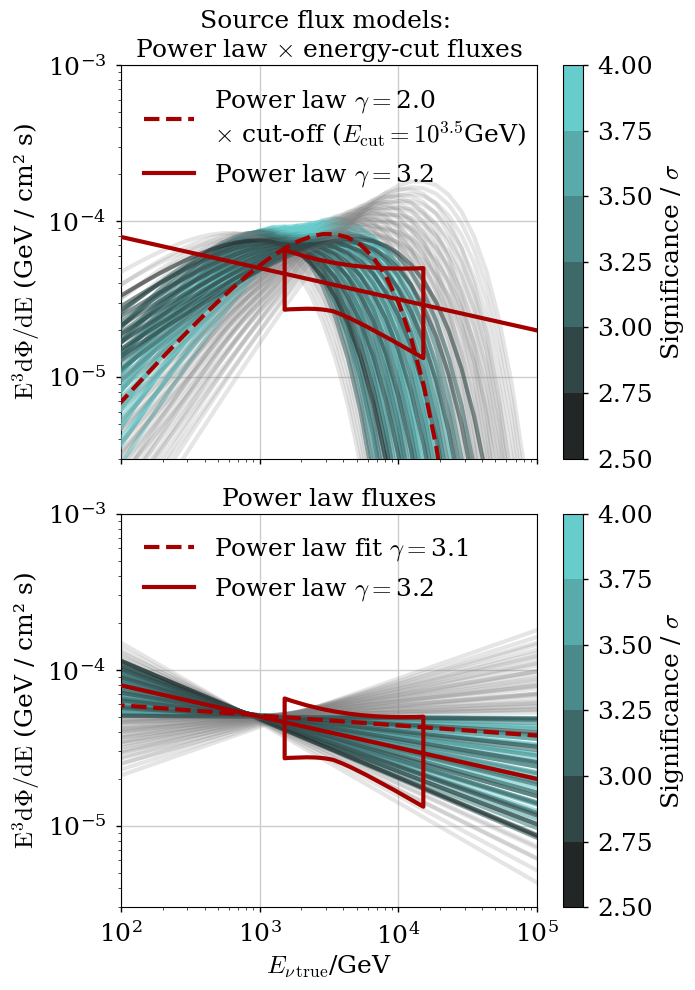

In [27]:
sq_deg = np.pi * delta_psi_max**2
x_evals = np.logspace(0, 9, 100)
y_scaling = 3

f, ax = plt.subplots(nrows=2, figsize=(7, 10), sharex=True)
ax[0].set_title("Source flux models: \n" + r"Power law $\times$ energy-cut fluxes")
ax[1].set_title("Power law fluxes")

cur_cmap = ListedColormap(
    sns.dark_palette(det_plotting["P-ONE"]["color"], reverse=False, n_colors=6)
)

sigma_min = 2.5  # np.min(pvals_ngc.significance)
sigma_max = 4  # np.max(pvals_ngc.significance)
color_projection = lambda x: cur_cmap((x - sigma_min) / (sigma_max - sigma_min))
sm = plt.cm.ScalarMappable(
    cmap=cur_cmap, norm=plt.Normalize(vmin=sigma_min, vmax=sigma_max)
)

for (Gamma_cut, logE_cut), series in pvals_ngc.groupby(["gamma_cut", "logE_cut"]):
    ## selecting results that are close to the original fit values
    mask = (np.abs(pivot_gamma_diff) < gamma_err) & (np.abs(pivot_norm_diff) < norm_err)
    if mask[Gamma_cut].loc[logE_cut]:
        alpha_val = 0.6
        col = color_projection(series.iloc[0]["significance"])
    else:
        alpha_val = 0.2
        col = "gray"

    # define the correctly normalized PL+cut flux for NGC 1068
    ngc_cut_flux_tmp = PLcut_flux(
        PHI_NGC * series.iloc[0]["flux_scaling"],
        Gamma_cut,
        logE_cut,
        E0_NGC,
        "powerlaw with cutoff",
    )
    cut = power_law(
        x_evals, ngc_cut_flux_tmp.E0, ngc_cut_flux_tmp.gamma, ngc_cut_flux_tmp.norm
    ) * cut_off(x_evals, 10**ngc_cut_flux_tmp.e_cut)

    ax[0].plot(
        x_evals,
        cut * (x_evals**y_scaling),
        color=col,
        alpha=alpha_val,
        zorder=10,
        lw=3,
    )

    # define the correctly normalized PL flux for NGC 1068
    # using the parameters obtained when fitting the PL+cut flux with PL
    tmp_ngc_flux = PL_flux(
        PHI_NGC * series.iloc[0]["out_pl_norm"],
        series.iloc[0]["out_pl_gamma"],
        E0_NGC,
        "powerlaw",
    )

    pl = power_law(x_evals, tmp_ngc_flux.E0, tmp_ngc_flux.gamma, tmp_ngc_flux.norm)

    ax[1].plot(
        x_evals,
        pl * (x_evals**y_scaling),
        color=col,
        alpha=alpha_val,
        zorder=1,
        lw=3,
    )
cut = power_law(
    x_evals, ngc_cut_flux.E0, ngc_cut_flux.gamma, ngc_cut_flux.norm
) * cut_off(x_evals, 10**ngc_cut_flux.e_cut)

ax[0].plot(
    x_evals,
    cut * (x_evals**y_scaling),
    color=det_plotting["Plenum-2"]["color"],
    ls="--",
    lw=3,
    zorder=20,
    label=rf"Power law $\gamma=${ngc_cut_flux.gamma}"
    + "\n"
    + rf"$\times$ "
    + rf"cut-off ($E_{{\rm cut}}=10^{{{ngc_cut_flux.e_cut:1.1f}}}$GeV)",
)

# PL fit from chosen ecut/gamma parameters
selection = pvals_ngc.loc[
    (pvals_ngc.gamma_cut == ngc_cut_flux.gamma)
    & (pvals_ngc.logE_cut == ngc_cut_flux.e_cut)
]
tmp_ngc_flux = PL_flux(
    PHI_NGC * selection.iloc[0]["out_pl_norm"],
    selection.iloc[0]["out_pl_gamma"],
    E0_NGC,
    "powerlaw",
)

pl = power_law(x_evals, tmp_ngc_flux.E0, tmp_ngc_flux.gamma, tmp_ngc_flux.norm)

ax[1].plot(
    x_evals,
    pl * (x_evals**y_scaling),
    color=det_plotting["Plenum-2"]["color"],
    ls="--",
    lw=3,
    zorder=20,
    label=rf"Power law fit $\gamma=${tmp_ngc_flux.gamma:1.1f}",
)


# error contour
# with energy range interval
x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
pl = power_law(x_evals, ngc_flux.E0, ngc_flux.gamma, ngc_flux.norm)

for ii, xe in enumerate(x_cont):
    tmp = power_law(xe, ngc_flux.E0, gamma_c_68, phi_c_68 / 1e3)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)


for axx in ax:
    axx.fill_between(
        x_cont,
        c_low * (x_cont**y_scaling),
        c_high * (x_cont**y_scaling),
        edgecolor=det_plotting["Plenum-2"]["color"],
        facecolor=(0, 0, 0, 0),
        lw=3,
        zorder=15,
    )
    axx.plot(
        x_evals,
        pl * (x_evals**y_scaling),
        label=rf"Power law $\gamma=${ngc_flux.gamma}",
        color=det_plotting["Plenum-2"]["color"],
        alpha=1,
        zorder=10,
        lw=3,
    )

    axx.set_yscale("log")
    axx.set_ylabel(rf"$\rm E^{{{y_scaling}}} d\Phi / dE$ (GeV / cm² s)")
    axx.set_xscale("log")
    if y_scaling == 3:
        axx.set_ylim(3e-6, 1e-3)
        axx.set_xlim(1e2, 1e5)
    elif y_scaling == 2:
        axx.set_ylim(1e-11, 1e-5)
        axx.set_xlim(1e2, 1e5)

    cb = plt.colorbar(sm, ax=axx)
    cb.set_label(r"Significance / $\sigma$")
    axx.legend(loc=2, frameon=False)
ax[1].set_xlabel(r"$E_{\nu \, \rm true}$/GeV")

f.tight_layout()
f.savefig(f"../../plots/ngc_paper/pl-cut_flux_model_matching_E{y_scaling}.pdf")
